In [1]:
import os.path as op
import sys
sys.path.append(op.abspath('../'))
sys.path.append(op.abspath('../../../'))

from os import environ
environ["ANAROOT"] = op.abspath('../../../')

# Apply Clustering in a brutal way

So far, the clustering using few variables of interest have not been successful. In this notebook, we aim to apply clustering algorithm in a more brutal-force approach, using mainly the 32 samples (standardised + brought to 0).

We also apply beforehand some cuts very efficient in signal.

Here are the ground rules:
- no amplitude variables are used
- the distributions are standardised and the zero is brought to the mean or pedestal

## Libraries

In [26]:
import itertools

import numpy as np

from lib import plot as lp, rootdata as lrd, data, clustering

from project import defs, files, col, normalize
from project.defs import dict_color_clu_labels
import data_cuts

import hdbscan



ImportError: cannot import name 'dict_color_clu_labels' from 'project.defs' (/home/anthony/3A_CS/projet_ATLAS/project/defs.py)

In [4]:
randomise_discretisation = True

## Load ROOT file

In [8]:
columns_already_computed = [
    'pos_max', #'pos_min',
    'std', 'pedestal',
    'std_pos', 'std_neg',
    'max', 'min', 'mean'
]

columns_to_compute = [
    'min_std_pos_neg',
    'min_std_pos_neg_redpn',
    'max_m_mean_red',
]

In [6]:
config_name = "BDT_SN"
file_path = files.get_path_processed_root(config_name)

if randomise_discretisation:
    variables_to_load = defs.list_samples_columns
else:
    variables_to_load = defs.list_samples_columns + columns_already_computed


dataframe = lrd.load_ROOT_into_dataframe(
    file_path,
    tree_name=defs.proc_tree_name,
    variables=variables_to_load,
    # cut="std!=0"
)

Time taken to load the ROOT files: 9.556927680969238
ROOT files loaded: /mnt/d/900GeV/processed/simulation/BDT_SN.root


In [7]:
if randomise_discretisation:
    files.randomise_discretisation(dataframe)

In [9]:
if randomise_discretisation:
    files.compute_voi(
        dataframe, 
        variables=columns_already_computed
    )

Time taken: 19.720250129699707


In [10]:
dataframe = dataframe.query("std!=0")

In [11]:
# # Get the formula of the columns to compute
# formula_columns = col.get_formula_columns(columns_to_compute)
# formula_column_labels = col.get_formula_labels(
#     columns_to_compute, defs.column_labels
# )
# column_labels = {
#     **defs.column_labels, **formula_column_labels
# }

# # Compute them
# dataframe = data.compute_vals(
#     dataframe, formula_columns
# )
column_labels = col.compute_all_columns(
    dataframe, 
    columns_to_compute,
    peak_voi=True,
    threshold_voi=True
)

In [12]:
# files.compute_peak_voi(
#     dataframe, zero_column="mean", red=True
# ) 
# files.compute_threshold_voi(
#     dataframe, ref_column="min", threshold=0.8
# ) 

Time taken: 5.375138282775879
Time taken: 5.756874322891235


### Cuts

In [ ]:
data_cuts.apply_signal_cuts(dataframe)

#### Events which don't reach zero after reaching the max

In [13]:
# len_before = len(dataframe)
# dataframe = dataframe.query("pos_first_neg_after_max!=-1")
# len_after = len(dataframe)
# print("Efficiency:", (len_before - len_after) / len_before)

Efficiency: 0.06154312146546951


####  Peaked background

In [14]:
# dataframe = dataframe.query("min_std_pos_neg_redpn > 0.02")
# len_after = len(dataframe)
# print("Efficiency:", (len_before - len_after) / len_before)

Efficiency: 0.17238558480026545


#### Events with many peaks w.r.t. max

In [15]:
# dataframe = dataframe.query("nb_peaks_sup_80_wrt_min == 1")
# len_after = len(dataframe)
# print("Efficiency:", (len_before - len_after) / len_before)

Efficiency: 0.865196819135412


#### Events with maximum at the end of the 32 samples

In [16]:
# dataframe = dataframe.query("pos_max <= 20")
# len_after = len(dataframe)
# print("Efficiency:", (len_before - len_after) / len_before)

Efficiency: 0.9068267705741301


#### Normalisation

In [17]:
normalize.normalise_samples(dataframe, zero_column="mean")

## DBSCAN

In [22]:
clu_label_name = "HDBSCAN"
clu_label_alias = "HDBSCAN"

In [19]:
features = defs.list_samples_columns

In [20]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=20, min_samples=1, 
    cluster_selection_epsilon=3)
clusterer.fit(dataframe[features])

/home/anthony/anaconda3/envs/ML4LTDB/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


HDBSCAN(cluster_selection_epsilon=3, min_cluster_size=20, min_samples=1)

In [23]:
dataframe[clu_label_name] = clusterer.labels_

The resulting dataframe is saved.

In [53]:
import uproot4
from lib.utils import try_makedirs

output_path = op.join(defs.proc_folder, "clustering")
full_output_path = op.join(output_path, 
    f"{config_name}_{clu_label_name}.root")
try_makedirs(output_path)
out_file = uproot4.recreate(full_output_path)
out_file[defs.proc_tree_name] = dataframe

In [24]:
np.unique(dataframe[clu_label_name])

array([-1,  0,  1,  2])

(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='HDBSCAN', ylabel='Number of events'>)

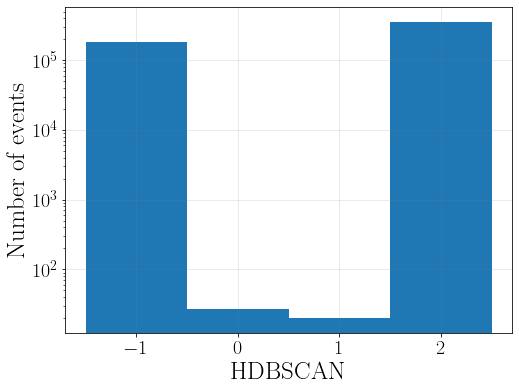

In [27]:
bins = clustering.get_edges_from_clust_labels(
    clusterer.labels_
)

lp.plot_hist(
    dataframe[clu_label_name],
    clu_label_alias,
    logscale=True,
    bins=bins,
)

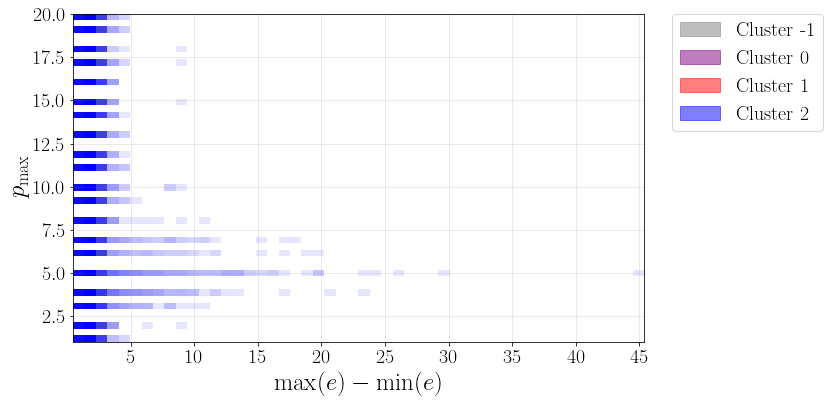

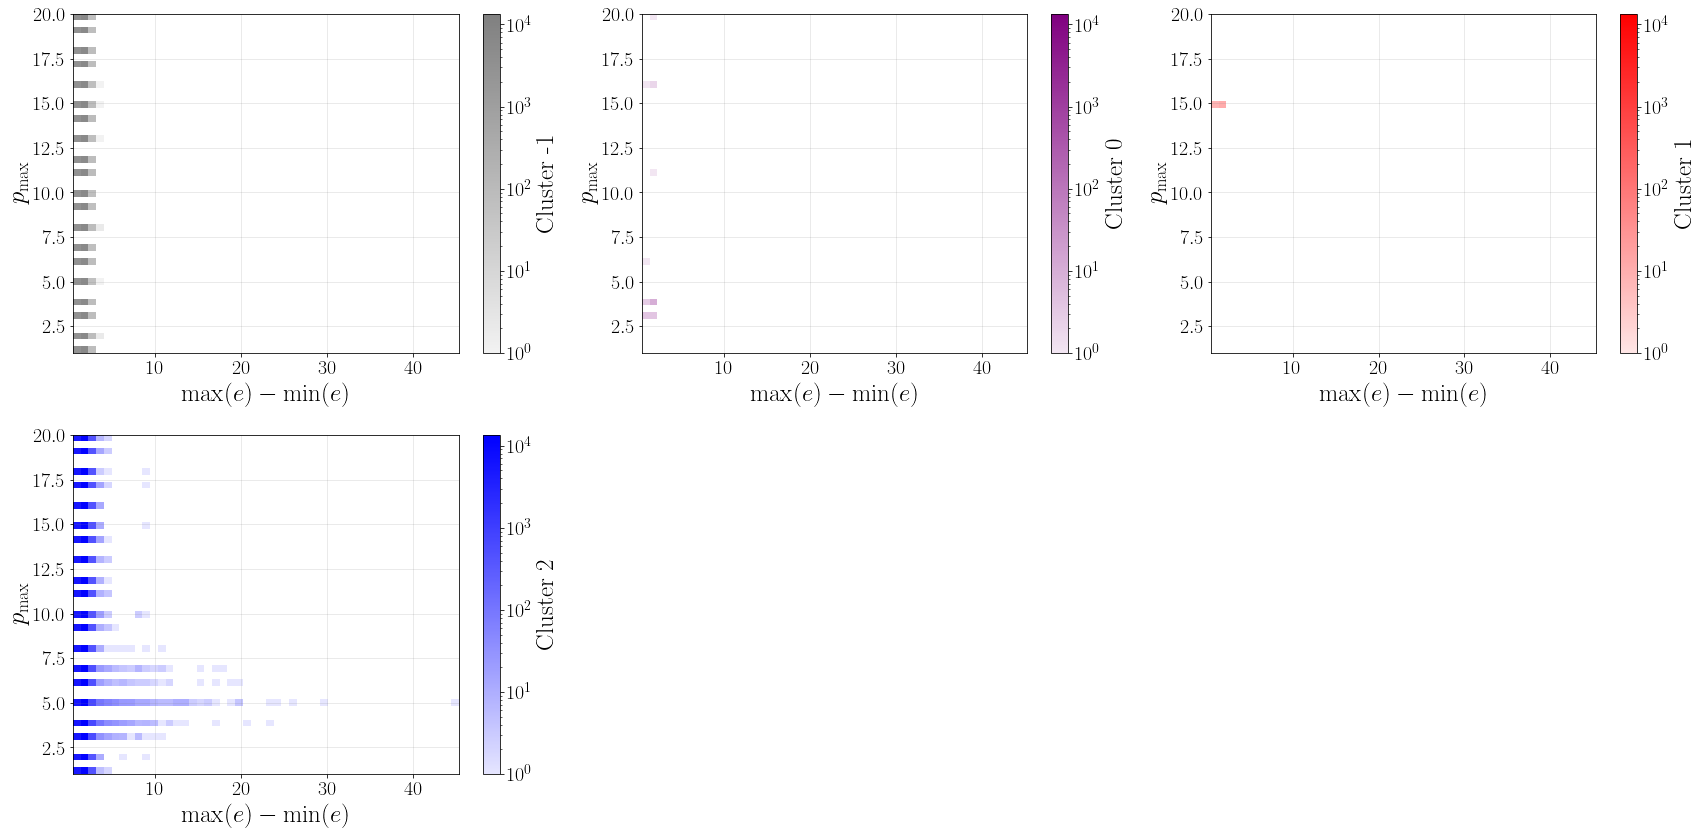

In [52]:
dataframe['max_m_mean'] = dataframe['max'] - dataframe['mean']
column_labels["max_m_mean"] = r"$\max(e) - \min(e)$"
clustering.plot_clusters_hist2d(
    dataframe, 
    ['max_m_mean', "pos_max"],
    column_labels,
    clu_label_name,
    logscale=True,
    dict_color_clu_cats=dict_color_clu_labels
)

(<Figure size 1728x864 with 4 Axes>,
 array([[<AxesSubplot:title={'center':'Cluster -1'}, xlabel='Time increment', ylabel='Output'>,
         <AxesSubplot:title={'center':'Cluster 0'}, xlabel='Time increment', ylabel='Output'>,
         <AxesSubplot:title={'center':'Cluster 1'}, xlabel='Time increment', ylabel='Output'>],
        [<AxesSubplot:title={'center':'Cluster 2'}, xlabel='Time increment', ylabel='Output'>,
         <AxesSubplot:>, <AxesSubplot:>]], dtype=object))

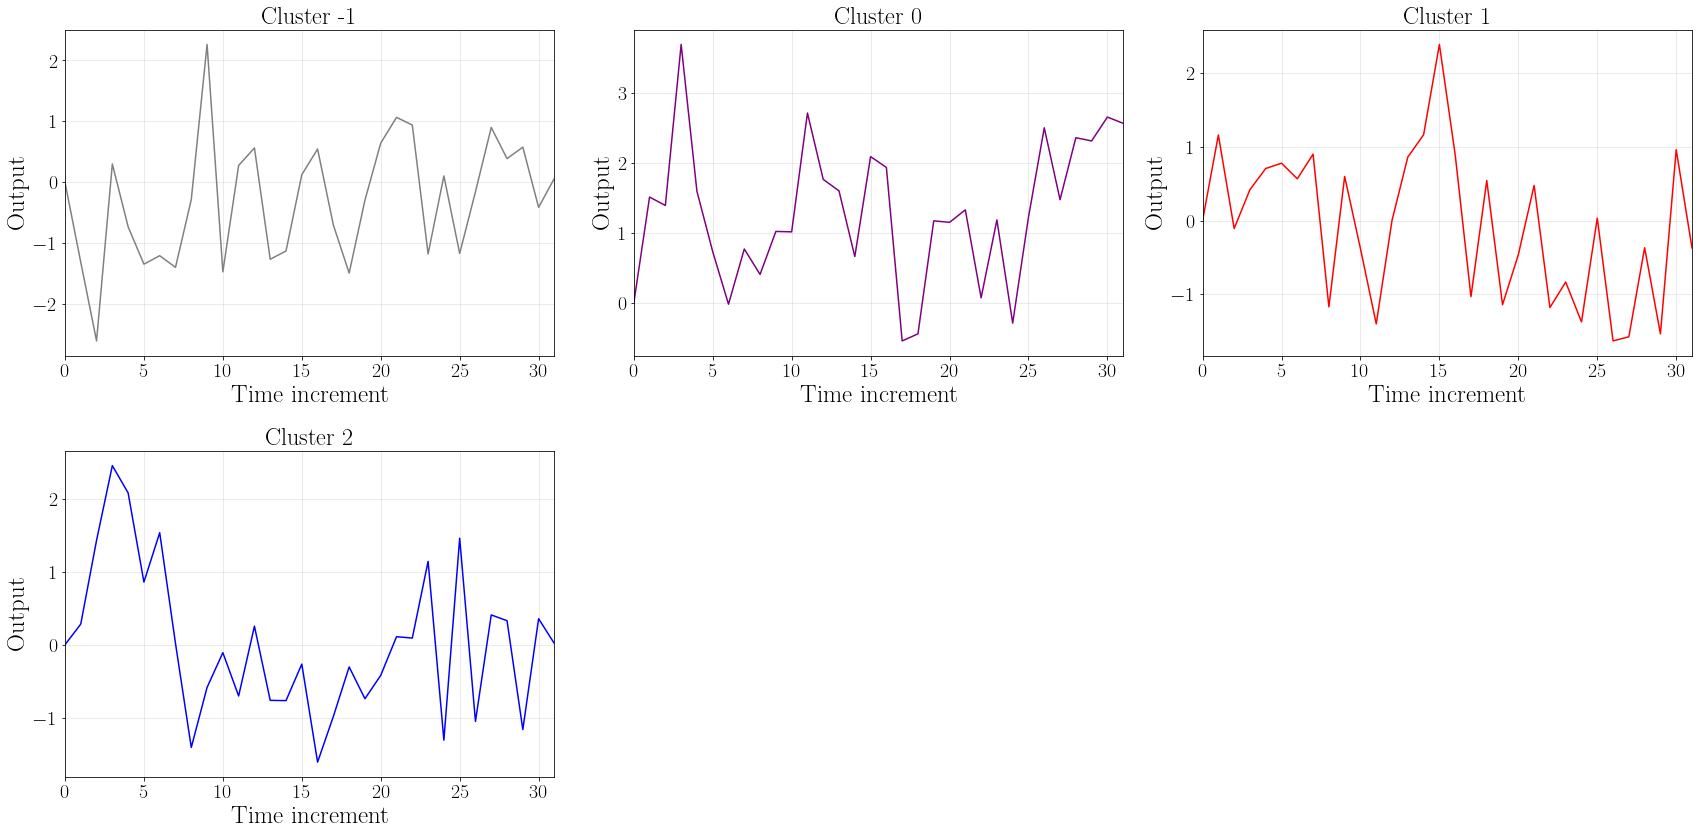

In [59]:
clustering.plot_samples_clusters(
    dataframe,
    clu_label_name,
    dict_color_clu_labels=dict_color_clu_labels
)

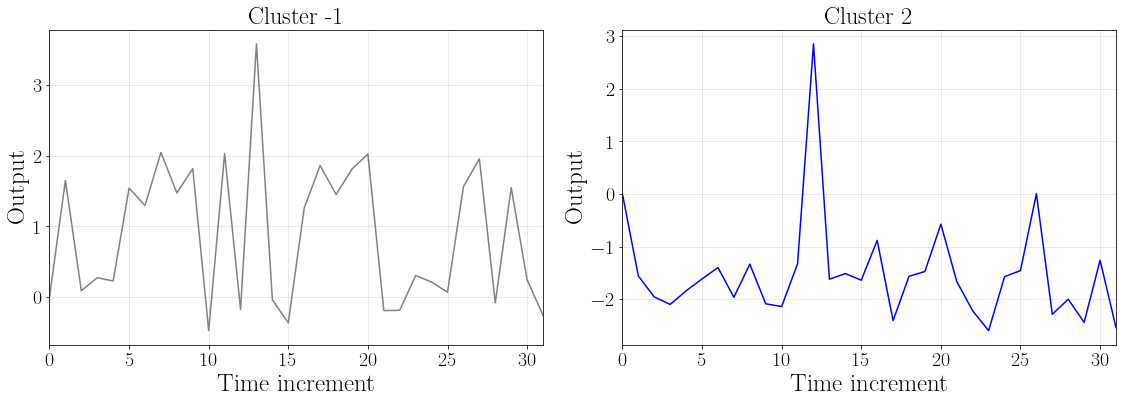

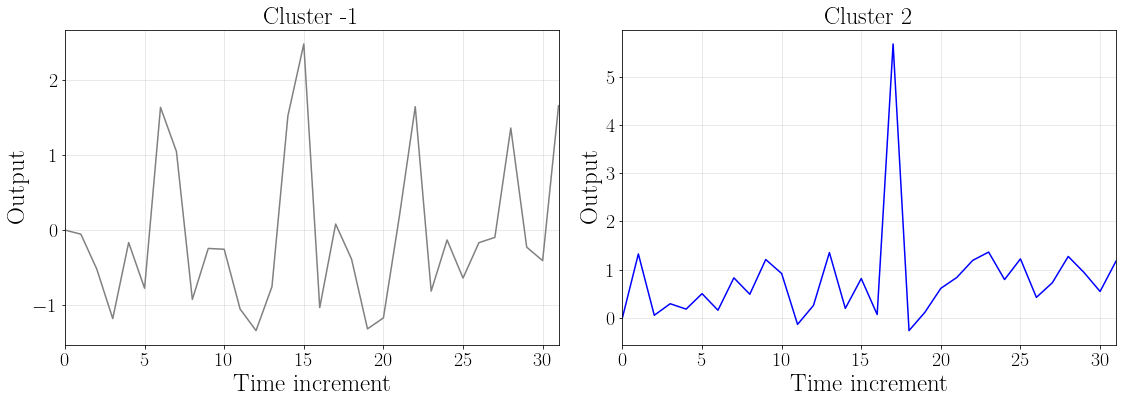

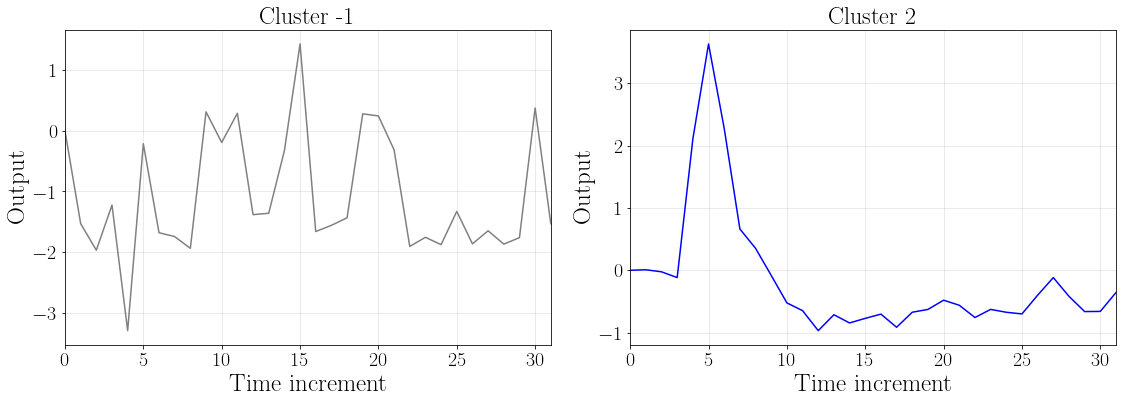

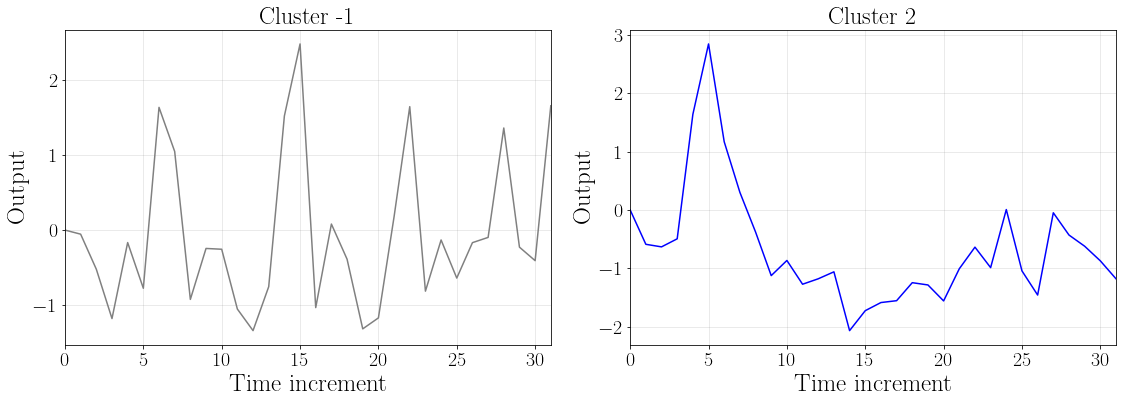

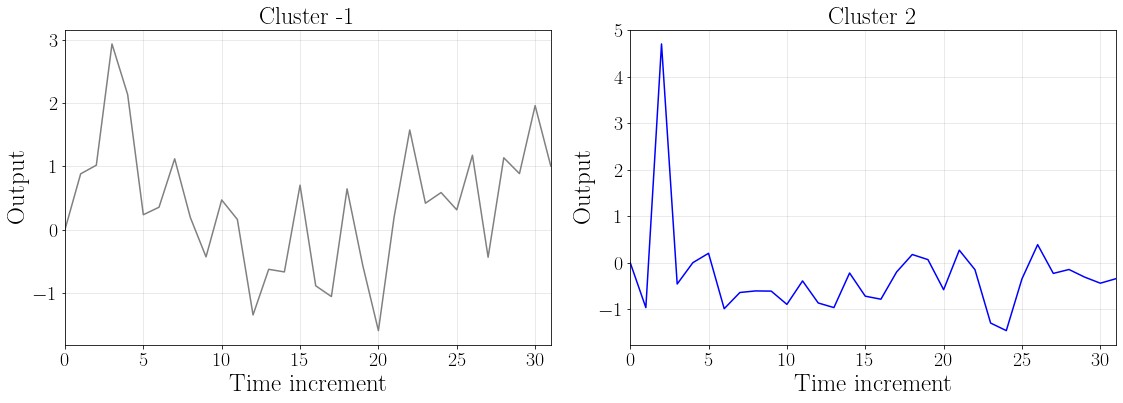

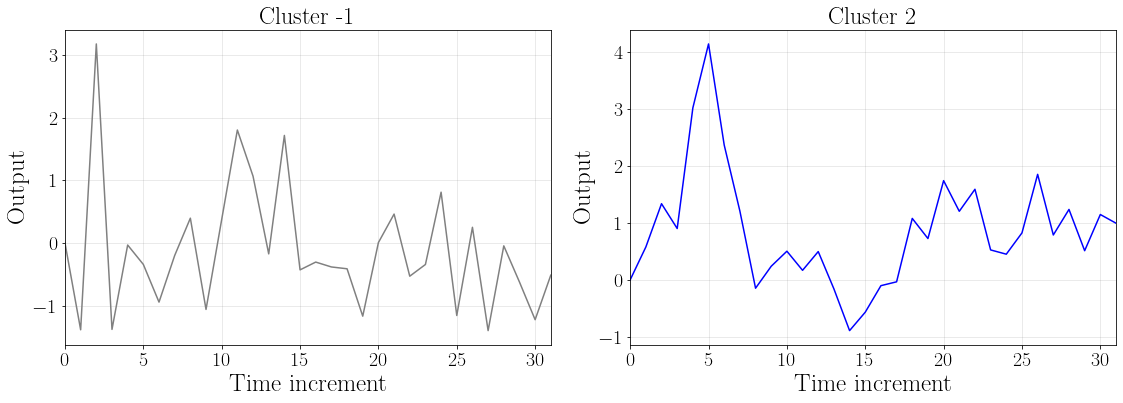

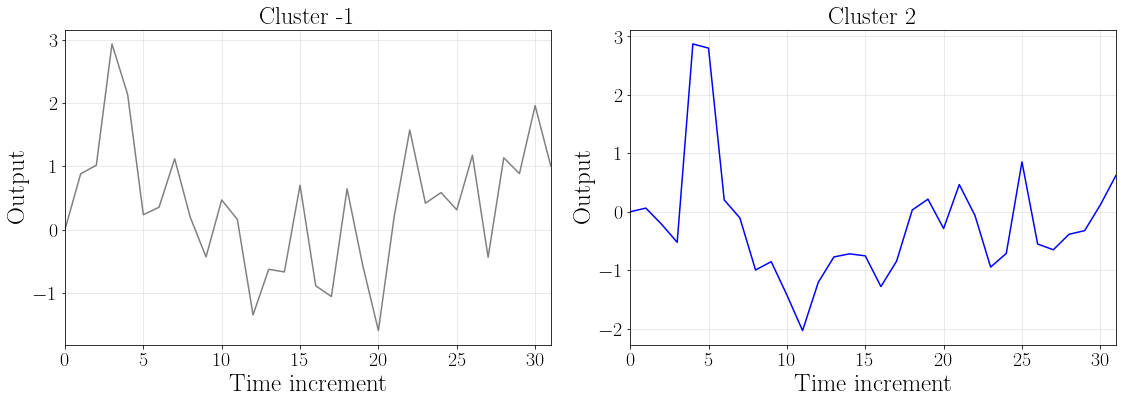

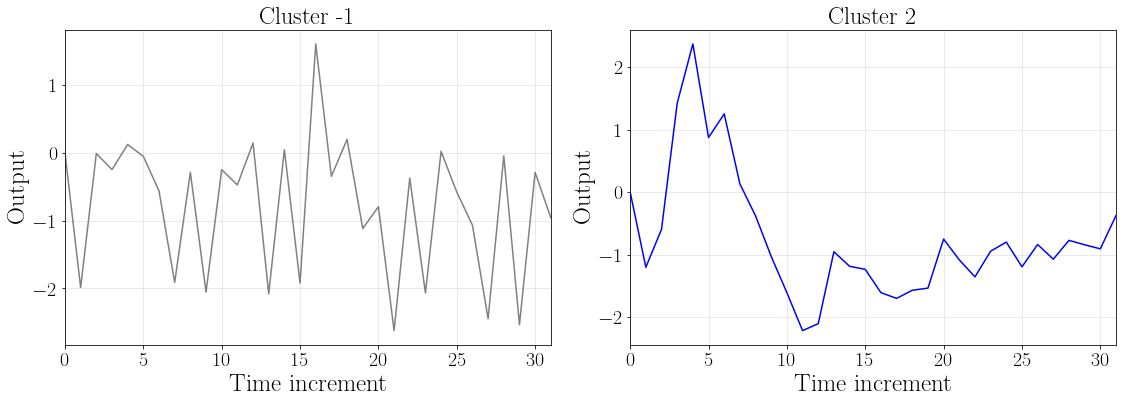

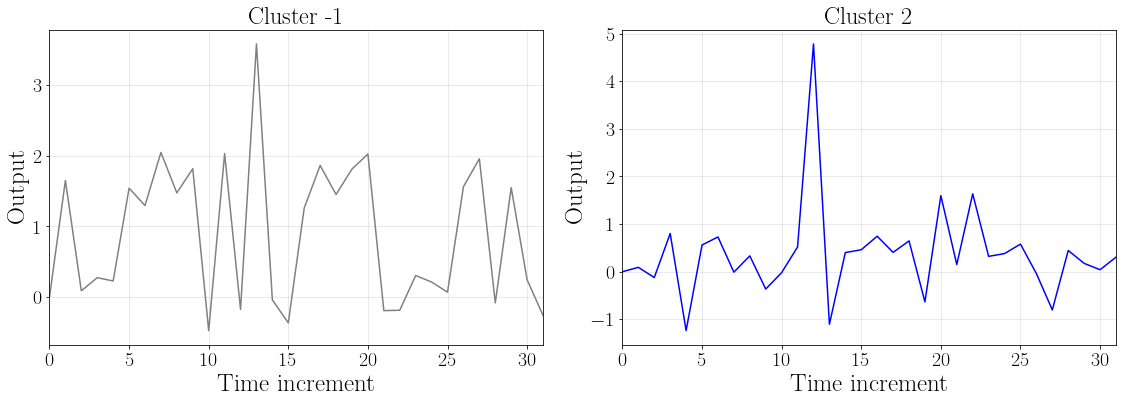

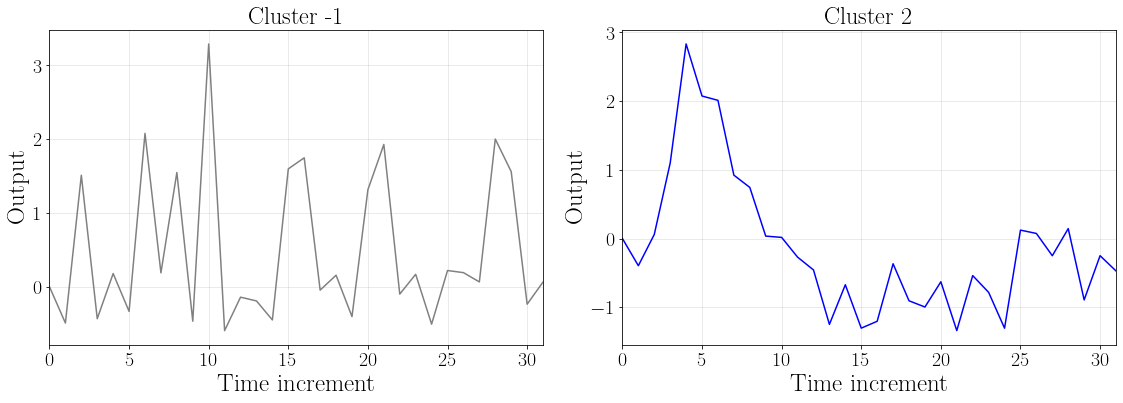

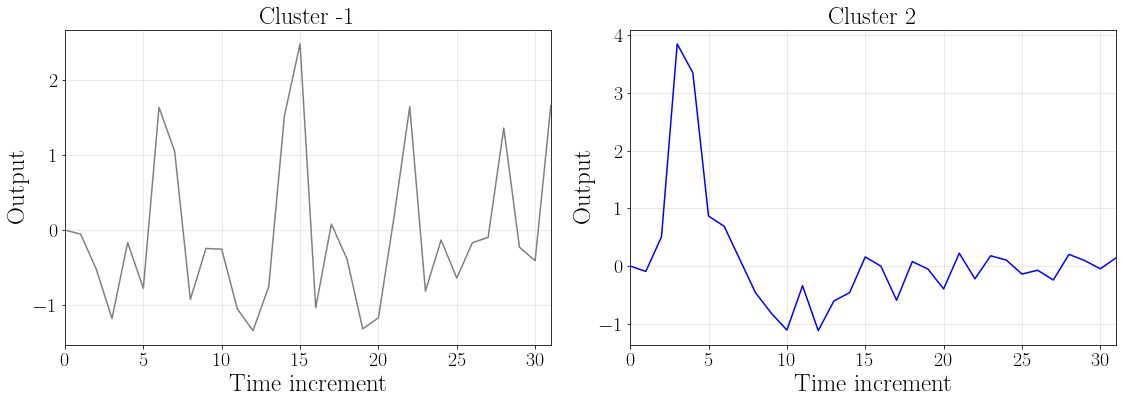

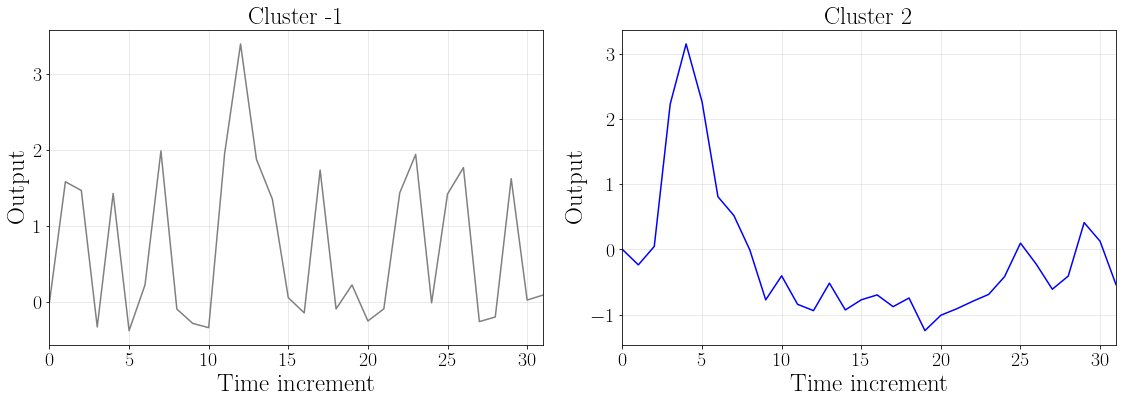

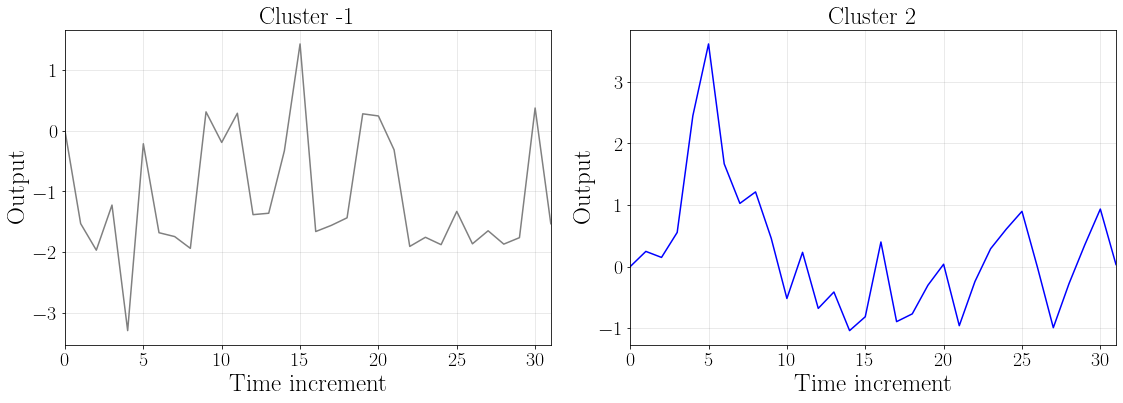

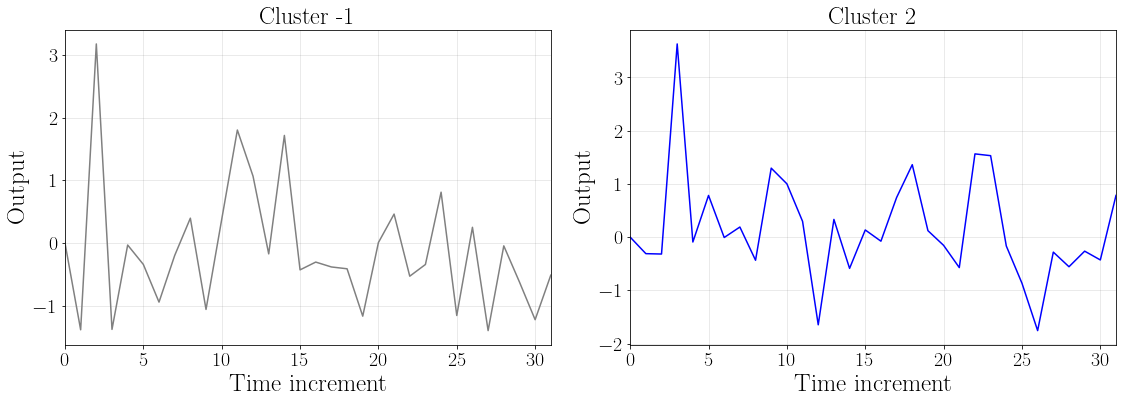

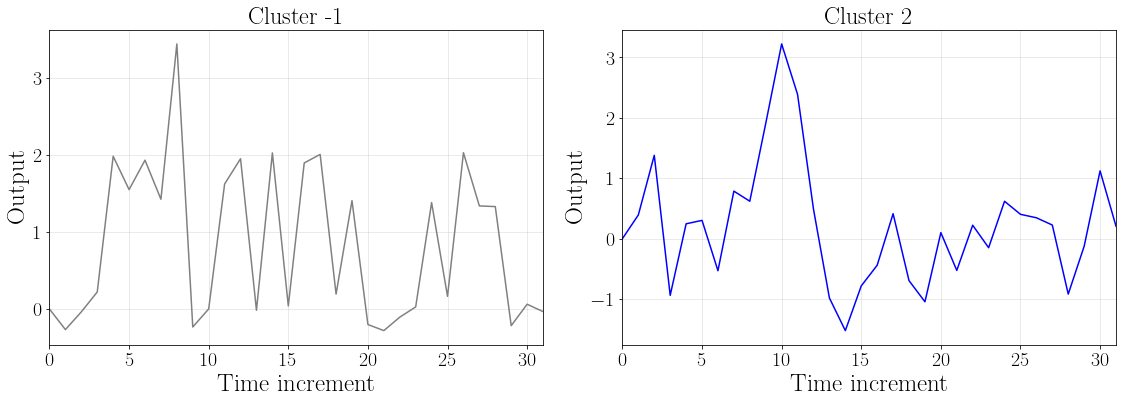

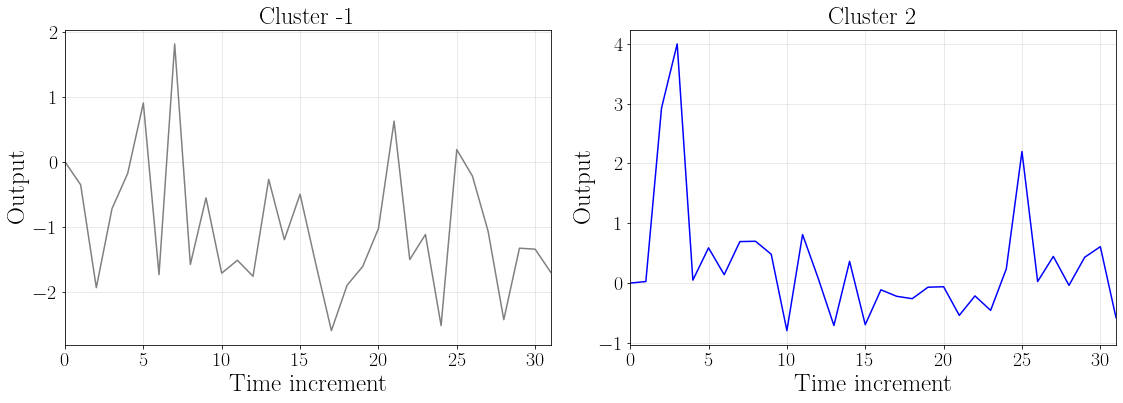

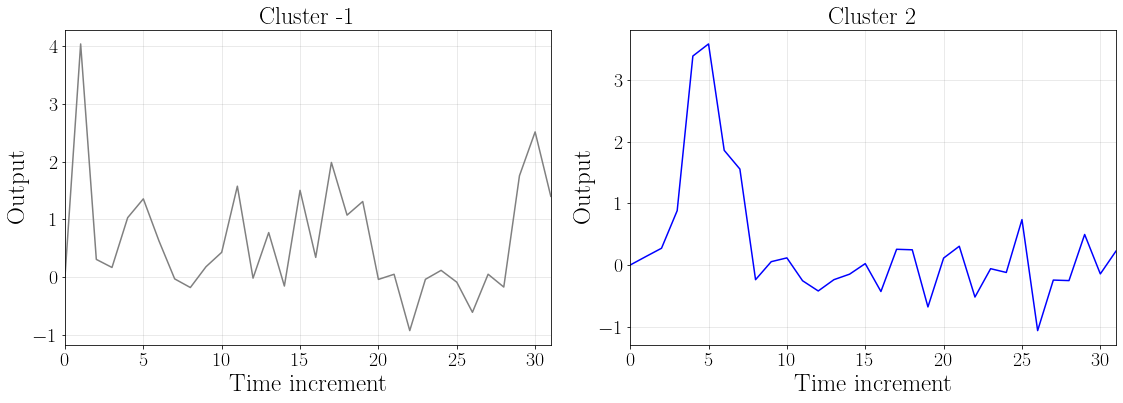

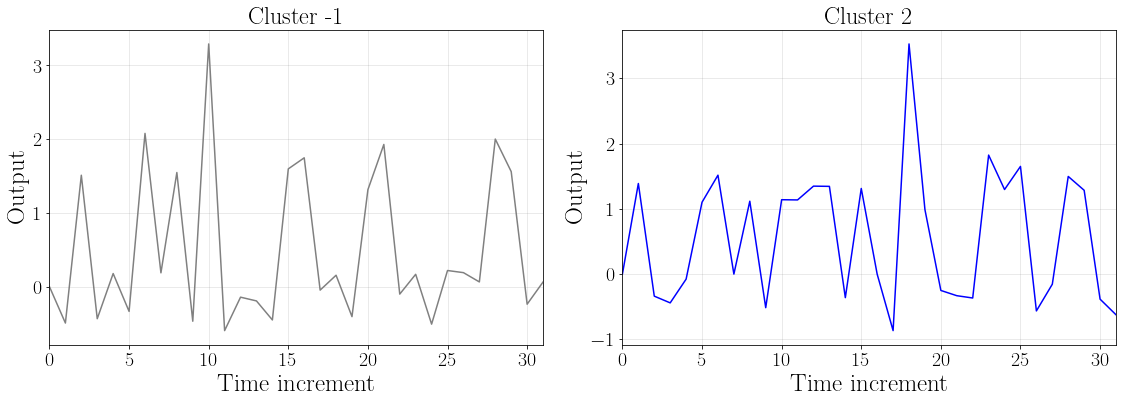

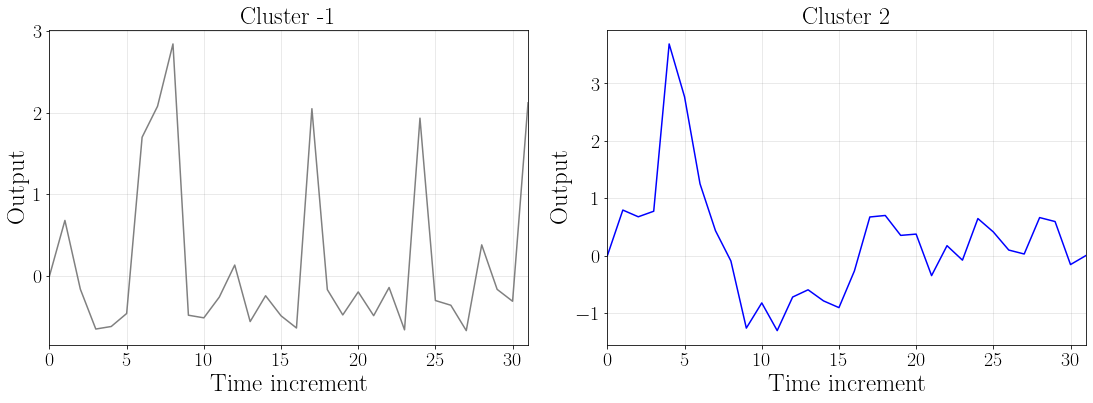

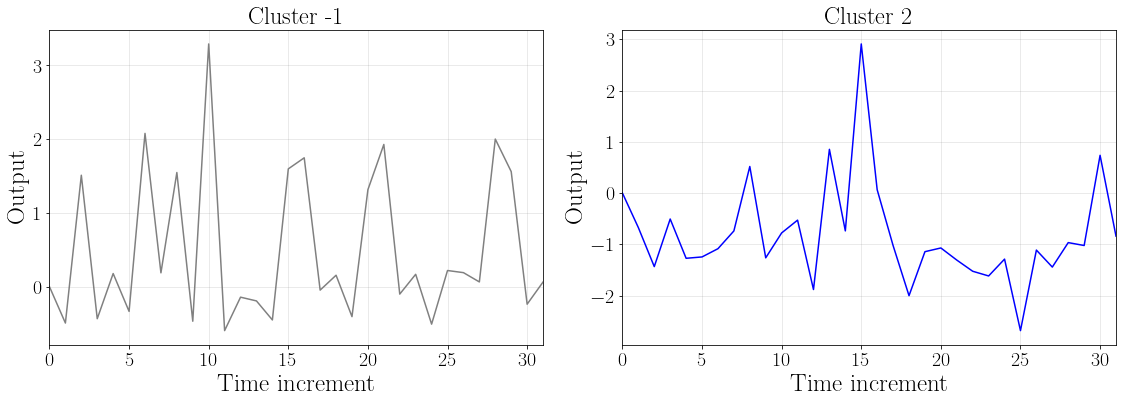

In [74]:
for i in range(20):
    clustering.plot_samples_clusters(
        dataframe.query('max_m_mean > 3'),
        clu_label_name,
        dict_color_clu_labels=dict_color_clu_labels
    )

### Analysis of the result

In [ ]:
signal_df = dataframe.query(f"{clu_label_name} == 1")
signal_df = signal_df.query("max - pedestal >= 4")
print(len(signal_df))

signal_df_red = signal_df.sample(n=min(100, len(signal_df)))

261
